# Disaster Tweet Identification with Topic Modeling via Non-negative Matrix Factorization

Megan Arnold

June 7, 2025

# Table of contents

1. Introduction
2. Data and Library Import
3. Exploratory Data Analysis
4. Feature engineering
    1. TFIDF
    2. Embedding
5. Model training
6. Hyperparameter tuning
7. Balancing the dataset
8. Results
9. Discussion
10. Conclusion
11. References


# Introduction

This project applies unsupervised learning to identify disaster-related content in social media posts. The dataset, sourced from Kaggle<sup>[1]</sup>, contains over 11,000 tweets labeled as either disaster-related or not. Disasters include topic/themes; such as, floods, fires, earthquakes, and disease. While the labels for this dataset are available, the goal is to use text vectorization and topic-modeling, via non-negative matrix factorization (NMF), to group the tweets into their content without relying on supervised learning. 

The motivation for this project is to help enable the performance of real-world disaster response. Quickly identifying emerging events, especially on platforms like Twitter, can help enable emergency response coordination and enhance situational awareness for first responders. By identifying the latent topics inherent in the dataset, we can cluster the tweets that correspond to various disasters types, even in the absense of labeled data.

The project i structured around the following steps:
- **Exploratory data analysis** to determine class imbalance, assess quality and language patterns, determine preprocessing requirements, and help guide the vectorization and modeling approaches.
- **Test preprocessing** to remove noise, such as URLs, emojis, and special characters. 
- **Feature Engineering** by applying vecotrization methods to the text data, including sparse representation with TFIDF, and a dense representation with an embedding model.
- Apply the **unsupervised non-negative matrix factorization (NMF)** algorithm to the vectorized training dataset. 
- **Hyperparameter tuning** to determine the ideal vectorization approach, vectorization parameters, and the number of topics to extract with the NMF algorithm.
- **Model Evaluation** using classification metrics; such as, accuracy, precision, recall, and f1 score, based on post-hoc mapping of the original dataset labels.
- **Analyze** the impact of the dataset imbalance and vectorization choice on the model performance
- State **recommendations** for future work and improvements to the methodology.

This project demonstrates the potential for unsupervised learning to extract insights from noisy user-generated text data, such as tweets. By leveraging topic modeling, we can identify the underlying themes in a disaster-related dataset; thus, potentially enabling more effective disaster reponse and coordination efforts.

# Importing data and libraries

Load dataset, libraries, and verify GPU availability

In [1]:
# Verify PyTorch installation and GPU availability

import torch

print("CUDA Available:", torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0))

CUDA Available: True
GPU Device Name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [ ]:
from collections import Counter
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize

pd.set_option('display.max_colwidth', None)

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data")
df = pd.read_csv(os.path.join(DATA_DIR, "tweets.csv"))

# Exploratory Data Analysis

## Data overview

The dataset used in this project was from Kaggle's **"Disaster Tweets"** dataset. Each tweet is labeled as either disaster-related (1) or non-disaster-related (0). Note: These labels are not considered during the modeling phase of the project, just the evaluation and results analysis. The dataset was collected using a **keyword matching process**, meaning the tweets were filtered based on the presence of certain keywords potentially related to disasters; however, it doesn't guarantee that the tweets are actually disaster-related. 

Below are some key features of the dataset that will be taking into consideration in the methodology:
- **Class Imbalance**: The dataset is imbalanced, with only 18.6% of the data labeled as "disaster" (1) and the rest as "non-disaster" (0).
    - The dataset contains 11,370 tweets, with 9,256 labeled as **"non-disaster"** (0) and 2,114 labeled as **"disaster"** (1).
Class imbalances can impact the post-hoc evaluation of the model. For example, if the model predicts all tweets as non-disaster, it would achieve an accuracy of 81.4% (the percentage of non-disaster tweets). However, this would not be a useful model for identifying disaster-related content. Therefore, the evaluation will focus on precision, recall, and f1 score to assess the model's performance in identifying disaster-related tweets.

- **Feature Description**::
    - **id**: unique identifier for each tweet
    - **keyword**: keyword from the tweet that was matched in the data mining process
    - **location**: location of the tweet
    - **text**: text of the tweet
    - **target**: label (1 for disaster, 0 for non-disaster)
- **Data Quality**:
    - The dataset is relatively clean, with no missing values in the target column. However, there are many missing values location columns, along with inconsistent naming conventions.
    - Dropped **keyword** because it was used in the data mining process and will be a redundant feature in the model once TFIDF is applied.
    - Dropped **location** because it is not-relevant to the analysis and has many missing values.
    - The **text** column will be the main feature used for vectorization and modeling. However, certain aspects will be **removed** from the text; such as:
        - URLs
        - Punctuation
        - Emojis
        - Special characters
        - Numbers
        - English stop words
        - Foreign characters and words
Ensuring a cleaned dataset will ensure the transformation with TFIDF and embedding models is effective. By removing noise from the text, we can focus on the meaningful words and tokens, instead of attempting to vectorize foreign characters, emojis, and other non-informative text.

The cleaned text will be used for vectorization and topic modeling. In the exploratory data analysis section, additional insights will be gained from the data, including the distribution of the tweet lengths and distribution of word frequencies.

Below are high level statistics about the dataset, including the class imbalance, number of tweets, and 5 examples of tweets from the dataset. Further analysis will be conducted regarding the distribution of tweet lengths, word frequencies, and other relevant features.

In [3]:
print("\n\nDataset Balance (Percent of positive samples):\n")
print(df["target"].mean())

print("\n\nCount of Positive and Negative Samples:\n")
print(df["target"].value_counts())

print("\n\nDF Information:\n")
print(df.info())

print("\n\nDF Head:\n")
print(df.head())

print("\n\nDF Location :\n")
print(df["location"].value_counts())

print("\n\nDF Keyword :\n")
print(df["keyword"].value_counts())



Dataset Balance (Percent of positive samples):

0.1859278803869833


Count of Positive and Negative Samples:

target
0    9256
1    2114
Name: count, dtype: int64


DF Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB
None


DF Head:

   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                                                                                                           text  \
0                 Communal 

## Word Frequency Analysis

A frequency analysis can provide insights into the distribution of words in the dataset. For example, are there a small number of words that are used most frequently (High peak, short tail), or does the distribution have a larger number of words that are used frequently (Low peak, long tail)? 

To answer this question, I plotted a histogram of the word frequencies of the dataset. The y-axis represents the number of words that occur at a given frequency, while the x-axis represents the frequency of the words. The histogram shows that there are a large number of words that occur only once (about 12000), and a small number of words that occur more frequently. In this distribution, almost 17,000 words of the 21,475 total words occur three times or less. 

This indicates that removing infrequent words will significantly reduce the noise in the dataset. This parameter will be tuned in the hyperparameter tuning section, with the parameter `min_df` in the TFIDF vectorization. 

Number of unique words that occur exactly once: 11725
Total unique words in corpus: 21475


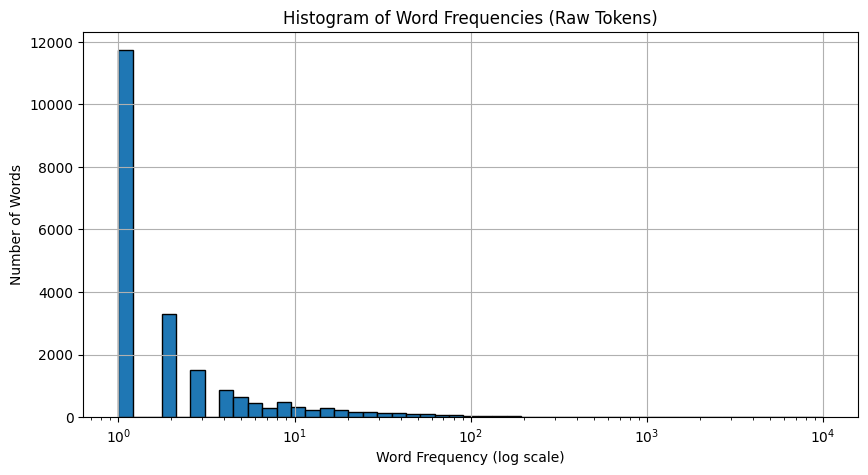

In [4]:
# Word frequency analysis
def tokenize(text):
    return re.findall(r'\b[a-z]{2,}\b', text.lower()) # Only keep words with 2 or more alphabetic characters

word_counter = Counter()
for text in df['text']:
    word_counter.update(tokenize(text))

word_freqs = np.array(list(word_counter.values()))

# Count how many words occurred exactly once
singleton_count = sum(1 for count in word_counter.values() if count == 1)
print(f"Number of unique words that occur exactly once: {singleton_count}")

# Total unique words
total_unique_words = len(word_counter)
print(f"Total unique words in corpus: {total_unique_words}")
plt.figure(figsize=(10,5))
plt.hist(word_freqs, bins=np.logspace(0, 4, 50), edgecolor='black')
plt.xscale('log')
plt.xlabel('Word Frequency (log scale)')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Frequencies (Raw Tokens)')
plt.grid(True)
plt.show()

## Distribution of Tweet Lengths

The below histogram shows that the distribution is left-skewed, with almost all tweets being less than 30 words long. The mean tweet length is 16.6 tokens, and the median is 18.0 tokens. To successfully model these topics, the vectorization method should be able to handle short text data effectively. The TFIDF vectorization will be used to transform the text data into a sparse representation, while the embedding model will be used to create a dense representation of the text data.


Average tweet length: 16.58496042216359
Median tweet length: 18.0
Max tweet length: 30
Min tweet length: 0


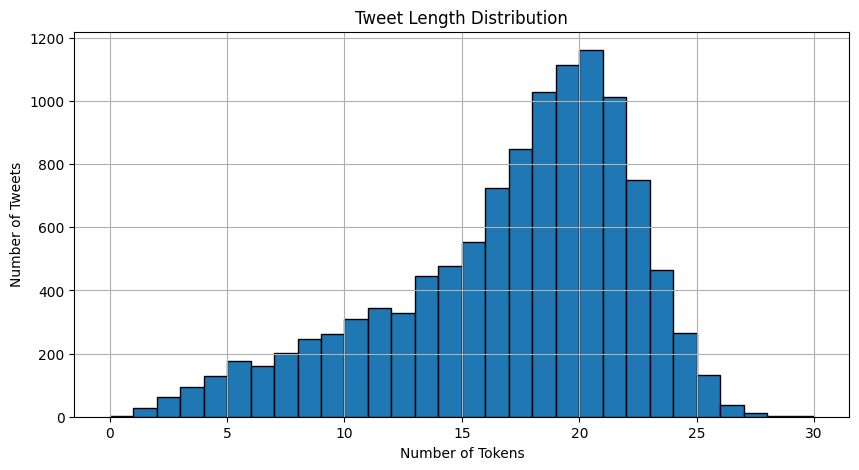

In [5]:

df['tweet_length'] = df['text'].apply(lambda x: len(tokenize(x)))
print(f"Average tweet length: {df['tweet_length'].mean()}")
print(f"Median tweet length: {df['tweet_length'].median()}")
print(f"Max tweet length: {df['tweet_length'].max()}")
print(f"Min tweet length: {df['tweet_length'].min()}")
plt.figure(figsize=(10,5))
plt.hist(df['tweet_length'], bins=30, edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Tweets')
plt.title('Tweet Length Distribution')
plt.grid(True)
plt.show()

## Sample Tweets

- **Low-Token Tweets** typically contain emojis, short phrases, or slang. I expect these tweets to be more challenging for the model to classify, as there isn't significant contextual information to extract.
- **High-Token Tweets** typically contain more complete sentences, more context, andd entire phrases/quotes. I expect these tweets to be easier for the model to classify, as there is more context and information to extract.

In [6]:
## Samples of tweets with low token count
low_token_tweets = df[df['tweet_length'] < 5]
print("\n\nSamples of tweets with low token count:\n")
print(low_token_tweets[['text', 'target']].head(20))



Samples of tweets with low token count:

                                                               text  target
74                             o_O ! I think I felt your aftershock       0
87   И снова о кризисе демографии (Yakov_Z) https://t.co/BlgYuNumDG       0
136                                 But... The airplane accident...       1
176                                 Grover Airplane Accident Doctor       0
216                                       “ambulance nurses” ♥️♥️♥️       0
226                                        You must be annihilated!       0
266                                        Thot status: annihilated       0
275                                        Thot Status: Annihilated       0
287                                      i want u like annihilation       0
303                            ANNIHILATION https://t.co/3QhIwn016i       0
312                                     Annihilation! One a my favs       0
320                                          

In [7]:
## Samples of tweets with low token count
low_token_tweets = df[df['tweet_length'] > 25]
print("\n\nSamples of tweets with high token count:\n")
print(low_token_tweets[['text', 'target']].head(10))



Samples of tweets with high token count:

                                                                                                                                              text  \
241   All the promises that have perished in the name of a almond. It makes me want to cry. It makes me want to curse des… https://t.co/zUlARoqepO   
249   All the apples that have perished in the name of a adderall pill. It makes me want to cry. It makes me want to curs… https://t.co/aeWJnrzC7B   
597   what if iz*one is gonna disband too? that they just said that iz*one will resume so the fans won’t worry but in the… https://t.co/Zy16AGQe42   
727                  If you are leaving Labour then you have done exactly what the right of the party wants you to do. In the words of Tony Benn:…   
920   I shot one of two Colts I had aimed at him, the one in my left hand, before Trent could pull the trigger of his Rem… https://t.co/asYxjXnFd0   
930   “I got me a deck of cards in my shirt pocket, if y

## Word Frequency Distribution

To determine a starting point for the maximum number of features in the TFIDF vectorizer, I plotted the word frequency by rank. The x-axis represents the rank of the word (1 being the most frequent word, 2 being the second most frequent word, etc.). The y-axis represents the total number of times that word appears in the corpus. 

I used the word frequency by rank to help imform my choice for max-features in the TF-IDF vecotrizer. The chart below shows that there is an elbow around 1500 words. I will use this as my first iteration of the TFIDF vectorizer. This is a hyperparameter that can be tuned if the model's performance; however, increasing the number of features will increase the dimensionality of the data and may lead to overfitting.

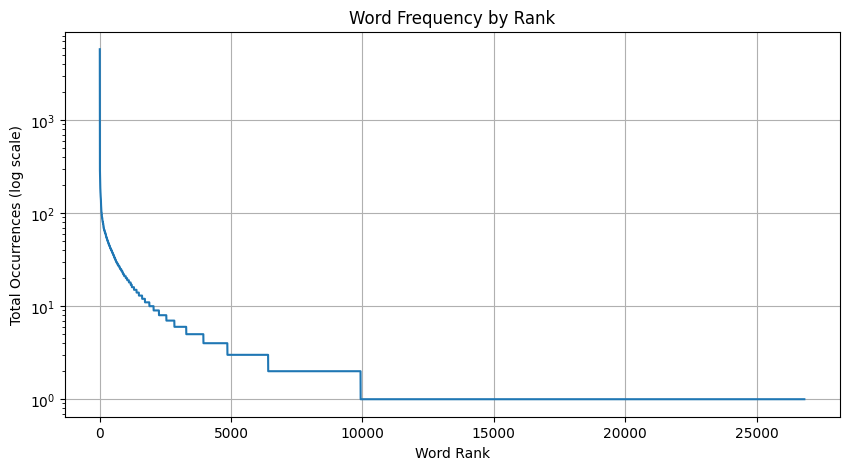

In [8]:
# Word frequency distribution
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(df['text'])

word_freqs = np.asarray(X_counts.sum(axis=0)).ravel()
vocab = vectorizer.get_feature_names_out()

# Sort for display
sorted_freqs = np.sort(word_freqs)[::-1]

plt.figure(figsize=(10,5))
plt.plot(sorted_freqs)
plt.xlabel('Word Rank')
plt.ylabel('Total Occurrences (log scale)')
plt.title('Word Frequency by Rank')
plt.yscale('log')
plt.grid(True)
plt.show()


## Word Cloud

To get a better understanding of the most common words before and after cleaning, I created a word cloud of the corpus. We can see that before cleaning, the word cloud contains many common words, such as "the", "https", "to", etc. After cleaning, the word cloud contains more meaningful words that have the potential to provide the model with the necessary insights to classify the tweets.

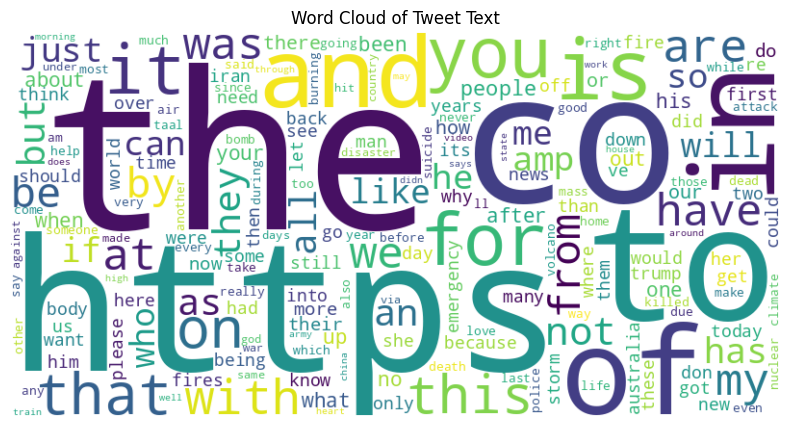

In [9]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counter)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

## Clean Text and Remove Stop words

Some of the tweets contain hyperlinks, which are not useful for our analysis. These will be removed in the preprocessing step before the TFIDF vectorizor or mebeding models are applied to the corpus. Additionally, english stop words will be removed to reduce uninformative words in the dataset.

- [x] Remove hyperlinks
- [x] Remove stop words
- [x] Remove punctuation
- [x] Remove numbers
- [x] Remove special characters

In [10]:
def clean_tweet(text):
    # Remove emojis (unicode ranges covering emoticons, symbols, pictographs, flags, etc.)
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags
        "\U00002500-\U00002BEF"  # chinese characters
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010ffff"
        "\u200d"
        "\u2640-\u2642"
        "\u2600-\u2B55"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"  # dingbats
        "\u3030"
        "]+",
        flags=re.UNICODE
    )

    text = emoji_pattern.sub(r'', text)              # remove emojis
    text = re.sub(r'\d+', '', text)                     # remove numbers
    text = re.sub(r'http\S+', '', text)              # remove URLs
    text = re.sub(r'@\w+', '', text)                 # remove mentions
    text = re.sub(r'#\w+', '', text)                 # remove hashtags
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)      # remove punctuation/special chars
    text = text.lower().strip()                      # lowercase and strip
    return text

df['cleaned_text'] = df['text'].apply(clean_tweet)


In [11]:
# Verify hyperlinks removed
id = 241
print(f"Original tweet: {df.iloc[id]['text']}")
print(f"Cleaned tweet: {df.iloc[id]['cleaned_text']}")

# Verify emojis removed
id = 216
print(f"Original tweet: {df.iloc[id]['text']}")
print(f"Cleaned tweet: {df.iloc[id]['cleaned_text']}")

# Verify only english characters
id = 87
print(f"Original tweet: {df.iloc[id]['text']}")
print(f"Cleaned tweet: {df.iloc[id]['cleaned_text']}")

# Verify numbers removed
id = 466
print(f"Original tweet: {df.iloc[id]['text']}")
print(f"Cleaned tweet: {df.iloc[id]['cleaned_text']}")

Original tweet: All the promises that have perished in the name of a almond. It makes me want to cry. It makes me want to curse des… https://t.co/zUlARoqepO
Cleaned tweet: all the promises that have perished in the name of a almond it makes me want to cry it makes me want to curse des
Original tweet: “ambulance nurses” ♥️♥️♥️
Cleaned tweet: ambulance nurses
Original tweet: И снова о кризисе демографии (Yakov_Z) https://t.co/BlgYuNumDG
Cleaned tweet: yakovz
Original tweet: 190 people arrested for arson!
Cleaned tweet: people arrested for arson


## Word Cloud after cleaning

After removing hyperlinks, stop words, punctuation, numbers, special characters, and emojis. I vectorized the values with the TF-IDF algorithm. 

**TF-IDF** stand for Term Frequency x Inverse Document Frequency.
It is a measure of how important a word is to a document in a corpus. It is calculated by multiplying the term frequency of a word in a single document by the inverse document frequency of the word across all documents. This means that if a word is rare, but commonly used in a specific document, it will have a high TF-IDF score. Conversely, if a word is common across all documents, despite being used in a specific document, it will have a lower TF-IDF score. 

The word cloud below shows the highest TF-IDF scores for the words in the corpus. The larger the word, the higher the TF-IDF score. This means that these words are more important to the tweets in the corpus. The words like "emergency" and "storm" are related to disasters, while words like "im", "dont" and "like" are common words that are not related to disasters. This implies that my max_df and min_df parameters can be further tuned to remove these common words. I'll address this in the hyperparameter tuning section.

Top 15 words after cleaning:
just: 152.64
like: 148.93
amp: 141.85
people: 139.64
im: 128.47
dont: 95.32
new: 83.29
time: 80.88
need: 77.44
know: 75.08
years: 66.25
think: 65.03
man: 62.94
emergency: 62.35
storm: 61.42


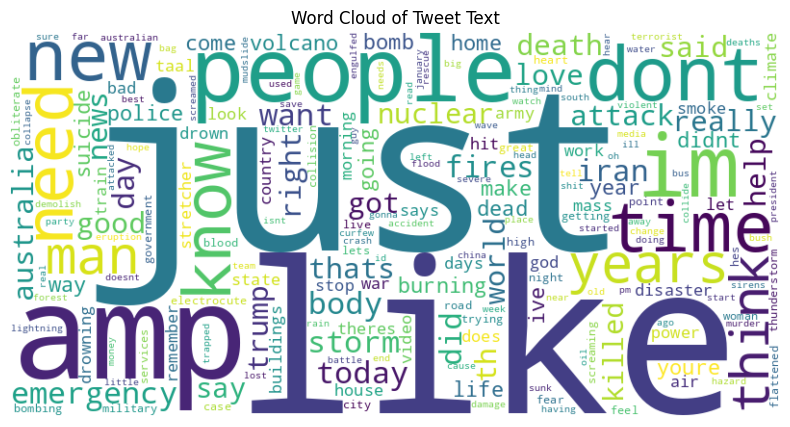

In [12]:
vectorizer = TfidfVectorizer(
    max_df=0.95, # Ignore words that appear in more than 95% of the tweets
    min_df=10, # Only keep words that appear in at least 10 tweets
    stop_words='english',
    token_pattern=r'\b[a-z]{2,}\b',  # Only keep words with 2 or more alphabetic characters
    ngram_range=(1, 1)  # Unigrams only
)

train_vectorized = vectorizer.fit_transform(df['cleaned_text'])

word_list_cleaned = vectorizer.get_feature_names_out()
word_count_cleaned = train_vectorized.sum(axis=0).A1

word_freq_cleaned = list(zip(word_list_cleaned, word_count_cleaned))
word_freq_cleaned = sorted(word_freq_cleaned, key=lambda x: x[1], reverse=True)
print("Top 15 words after cleaning:")
for word, freq in word_freq_cleaned[:15]:
    print(f"{word}: {float(freq):.2f}")

    
wordcloud_cleaned = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq_cleaned))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()


# Feature Engineering

## Train-test split

In the below cell. I'll split the data into a training and test set. The training set will be used to train and tune the model, while the test set will be used to evaluate the model's performance. The split will be 80% for training and 20% for testing. Because the dataset is imbalanced, I will use stratified sampling to ensure that the training and test sets have the same distribution of labels as the original dataset. This may not be completely necessary because about 80% of the data is non-disaster (0) and 20% is disaster (1). With a sample size of around 11,000, there should be enough for randomness to take care of the balance. However, it is a good practice to use stratified sampling when dealing with imbalanced datasets.

In [13]:
# Train-test split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])
print("\n\nTrain set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("Train set target distribution:\n", df_train['target'].value_counts(normalize=True))
print("Test set target distribution:\n", df_test['target'].value_counts(normalize=True))



Train set shape: (9096, 7)
Test set shape: (2274, 7)
Train set target distribution:
 target
0    0.814094
1    0.185906
Name: proportion, dtype: float64
Test set target distribution:
 target
0    0.813984
1    0.186016
Name: proportion, dtype: float64


## TFIDF Vectorization

**TF-IDF** stand for Term Frequency x Inverse Document Frequency<sup>[3]</sup>.

It is a measure of how important a word is to a document in a corpus. It is calculated by multiplying the term frequency of a word in a single document by the inverse document frequency of the word across all documents. This means that if a word is rare, but commonly used in a specific document, it will have a high TF-IDF score. Conversely, if a word is common across all documents, despite being used in a specific document, it will have a lower TF-IDF score. 

TF-IDF is well-suited to this dataset because tweets are short and often contain a lot of noise, such as URLs, emojis, and special characters. Using TFIDF enables us to emphasize distrinctive terms and downweight comon ones; implying that it can help the model focus on the most informative words in the tweets. It also produces a sparse representation of the text data, which is ideal for non-negative matrix factorization (NMF) topic modeling<sup>[4]</sup>. I'll explain more about embedding models vs TFIDF in the results analysis section, as embedding models are a dense representation of the text data. 

The parameters in the TF-IDF vectorizer are:
- **max_df**: This parameter is used to ignore terms that have a document frequency higher than the given threshold. This is useful for removing common words that are not useful for our analysis. I will set this to 0.95, meaning that any word that appears in more than 95% of the documents will be ignored.
- **min_df**: This parameter is used to ignore terms that have a document frequency lower than the given threshold. This is useful for removing rare words that are not useful for our analysis. I will set this to 10, meaning that any word that appears in less than 10 documents will be ignored.
- **ngram_range**: This parameter is used to specify the range of n-grams to be extracted from the text. I will set this to (1, 1), meaning that only unigrams will be extracted. In hyper parameter tuning, it'll be set to (1, 2) to include bigrams as well.
- **stop_words**: This parameter is used to specify the stop words to be removed from the text. I will set this to 'english', meaning that the default English stop words will be removed.
- **token_pattern**: This parameter is used to specify the token pattern to be used for extracting tokens from the text. I will set this to r'\b[a-z]{2,}\b', meaning that only tokens with 2 or more characters will be extracted. Since I already converted the text to lowercase, this will help remove any tokens that are not words. This is a parameter that can be tuned in the hyperparameter tuning section.

In [14]:
# Vectorization
vectorizer = TfidfVectorizer(
    max_df=0.95, # Ignore words that appear in more than 95% of the tweets
    min_df=10, # Only keep words that appear in at least 10 tweets
    stop_words='english',
    token_pattern=r'\b[a-z]{2,}\b',  # Only keep words with 2 or more alphabetic characters
    ngram_range=(1, 1)  # Unigrams only
)
X_vectorized = vectorizer.fit_transform(df_train['cleaned_text'])
print(f"Shape of TF-IDF matrix: {X_vectorized.shape}")
print(f"Number of features (unique words): {X_vectorized.shape[1]}")
print(f"Number of samples: {X_vectorized.shape[0]}")

Shape of TF-IDF matrix: (9096, 1567)
Number of features (unique words): 1567
Number of samples: 9096


## Embedding

Embedding is a technique that represents the entire phrase as a single vector<sup>[5]</sup>. The purpose of this is to capture the meaning of the phrase, instead of just the frequency of the individual words. The dataset was generated by a keyword search, so the words aren't necessarily representative of the topic. For example, there were several tweets that contained the word "ablaze" but they weren't related to a disaster, but instead a quote from a book.

Embedding will create a dense matrix that will capture the meaning of the tweets, as opposed to identifying keywords only. Then I will apply non-negative matrix factorization (NMF) to extract the topics from the embedding. I will then compare this to the TFIDF model of vectorization to see if one method outperforms the other. This comparision will provide insights into how semantic meaning vs word frequency impacts the model's ability to identify disaster-related tweets using non-negative matrix factorization (NMF).

In [15]:
# embedding here

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # 384-dim
X_embed = embedding_model.encode(df_train['cleaned_text'].to_list(), show_progress_bar=True)
X_embed_norm = normalize(X_embed)
X_embed_norm_positive = X_embed_norm - X_embed_norm.min()

Batches: 100%|██████████| 285/285 [00:04<00:00, 70.09it/s]


# Model Training and Hyperparameter tuning

## Tuning the number of components and TF-IDF parameters

**Step 1:**
- **Purpose**: Tuning the number of components for the NMF model.
- **Vectorizers**: TF-IDF and Embedding

Using a grid search method, I will tune the number of components for the NMF model on both of the vectorized datasets. This will give me a good starting point for the number of topics to use when tuning the vectorization parameters. Having a large number of topics significantly increases the dimensionality of the data, which can lead to overfitting and performance issues. Identifying when there performance stagnates will help me determine the ideal number of topics to use in future sections. 

I test values in the of 5, 10, 15, 20, 30, 50, 100, 200, 300. To determine performance, I will use the f1 score, which is a measure of the model's ability to correctly classify the tweets as disaster-related or not. The f1 score is the harmonic mean of precision and recall, and is a good measure of the model's performance when dealing with imbalanced datasets.

Since the dataset is imbalanced, the naive baseline is 18.6% (the percentage of disaster-related tweets in the dataset). I will plot this as a horizontal line on the graph to compare the model's performance to this baseline.

**Results**:
We can see that both the TFIDF and embedding model outperform the naive baseline of 18.6%. However, the TFIDF model gets better performance with more topics, and plateaus around 50 topics. The embedding model was a gradual decrease in performance as the number of topics increases. **TFIDF significantly outperforming embedding is a critical finding**. Since the embedding model is a dense representation of the text data, it is designed for semantic similarity, not additive composition. The embedding model represents a single point in a high-dimensional vector space. It is not designed to be decomposed into additive components, which is what NMF does. Embedding models could be coupled with a cosine similarity clustering algorithm to identify similar tweets, but it is not suitable for NMF topic modeling. I'll use the embedding models to compare the balanced datasets for the sake of completeness, but the TFIDF model will be the primary focus of the analysis.


In [16]:
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.decomposition import NMF
from sklearn.metrics import f1_score, precision_score, recall_score


def label_topics(W, df, target_col='target', threshold=0.2):
    topic_assignments = W.argmax(axis=1)
    df = df.copy()
    df['topic'] = topic_assignments
    
    topic_disaster_rate = df.groupby('topic')[target_col].mean()
    topic_to_label = (topic_disaster_rate > threshold).astype(int)
    
    predicted = df['topic'].map(topic_to_label)
    return predicted, topic_to_label, topic_disaster_rate



def run_nmf_and_score(X, df, n_components, threshold=0.2):
    nmf = NMF(n_components=n_components, random_state=42, max_iter=500)
    W = nmf.fit_transform(X)
    
    predicted_labels, topic_to_label, topic_disaster_rate = label_topics(W, df, 'target', threshold)
    
    y_true = df['target']
    y_pred = predicted_labels
    
    return {
        'n_components': n_components,
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'topic_to_label': topic_to_label,
        'topic_disaster_rate': topic_disaster_rate,
        'topic_assignments': W.argmax(axis=1),
    }

# nmf_metrics_combined.csv exist, load it
if os.path.exists(os.path.join(DATA_DIR, "nmf_metrics.csv")):
    metrics_df = pd.read_csv(os.path.join(DATA_DIR, "nmf_metrics.csv"))

else:
    X_sources = {
        'tfidf': X_vectorized,
        'embedding': X_embed_norm_positive
    }

    all_results = []

    for name, X in X_sources.items():
        print(f"\n🔍 Vectorizer: {name}")
        
        for k in [5, 10, 15, 20, 30, 50, 100, 200, 300]:
            print(f"  ➤ NMF with {k} components...")
            result = run_nmf_and_score(X, df_train, n_components=k, threshold=0.2)
            result['vectorizer'] = name
            all_results.append(result)

    metrics_df = pd.DataFrame([
        {
            'vectorizer': r['vectorizer'],
            'n_components': r['n_components'],
            'f1': round(r['f1'], 3),
            'precision': round(r['precision'], 3),
            'recall': round(r['recall'], 3),
        }
        for r in all_results
    ])

    metrics_df.sort_values(by=['vectorizer', 'n_components'])

    # save results
    metrics_df.to_csv(os.path.join(DATA_DIR, "nmf_metrics.csv"), index=False)

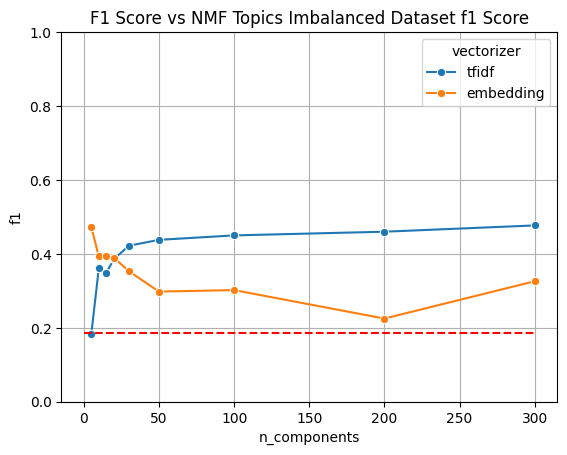

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=metrics_df, x='n_components', y='f1', hue='vectorizer', marker='o')
plt.title("F1 Score vs NMF Topics Imbalanced Dataset f1 Score")
plt.ylim(0, 1)
plt.hlines(y = 0.185, xmin=0, xmax=300, color='red', linestyle='--', label='Baseline F1 Score')
plt.grid(True)
plt.show()


Below is a function to label the topics post-hoc. This function will take the categories and determine a threshold for the topic purity. If the threshold is set to the naive baseline of 18.6%, then any topic that has a percentage of tweets labeled as disaster-related above this threshold will be considered a disaster-related topic. This will help us identify the topics that are most relevant to the disaster-related tweets in the dataset. Below is a very conservative threshold of 50% on a model with 10 topics. This was used to validate the function works as expected. This function will be used later to label the topics for the tuned balanced TFIDF vectorized model.

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_topic_labels(topic_labels, df, target_col='target', threshold=0.5):
    df = df.copy()
    df['topic'] = topic_labels
    
    topic_metrics = []

    for topic in sorted(df['topic'].unique()):
        subset = df[df['topic'] == topic]
        y_true = subset[target_col]
        
        # Predict based on the majority label for the topic
        predicted_label = 1 if y_true.mean() > threshold else 0
        y_pred = [predicted_label] * len(subset)
        
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        support = len(subset)
        disaster_rate = y_true.mean()
        
        topic_metrics.append({
            'topic': topic,
            'assigned_label': predicted_label,
            'disaster_rate': round(disaster_rate, 3),
            'support': support,
            'precision': round(precision, 3),
            'recall': round(recall, 3),
            'f1': round(f1, 3),
        })

    return pd.DataFrame(topic_metrics).sort_values(by='disaster_rate', ascending=False)



In [19]:

nmf_embedding = NMF(n_components=10, random_state=42)
nmf_embedding.fit(X_embed_norm_positive)
topic_labels_embedding = nmf_embedding.transform(X_embed_norm_positive)
topic_labels_embedding = np.argmax(topic_labels_embedding, axis=1)
topic_labels_embedding_df = evaluate_topic_labels(topic_labels_embedding, df_train)
print("\n\nTopic Labels for Embedding:\n")
print(topic_labels_embedding_df)


/home/megarnol/projects/MSDS_Notes_Playground/.venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(




Topic Labels for Embedding:

   topic  assigned_label  disaster_rate  support  precision  recall    f1
0      1               1          0.600       45        0.6     1.0  0.75
8      9               0          0.258     1723        0.0     0.0  0.00
5      6               0          0.254     1129        0.0     0.0  0.00
7      8               0          0.239     1806        0.0     0.0  0.00
1      2               0          0.155      400        0.0     0.0  0.00
6      7               0          0.123     2656        0.0     0.0  0.00
3      4               0          0.093      603        0.0     0.0  0.00
4      5               0          0.076      615        0.0     0.0  0.00
2      3               0          0.067      119        0.0     0.0  0.00


## Tuning TF-IDF parameters

**Step 2:**
- **Purpose**: Tuning the TF-IDF parameters to improve the model's performance.
- **Vectorizers**: TF-IDF

I will tune the TFIDF parameters to improve the model's performance. I will use the number of components from the previous step (50) and tune the following parameters:
- **max_df**: This parameter is used to ignore terms that have a document frequency higher than the given threshold
- **min_df**: This parameter is used to ignore terms that have a document frequency lower than the given threshold
- **ngram_range**: This parameter is used to specify the range of n-grams to be extracted from the text
- **token_pattern**: This parameter is used to specify the token pattern to be used for extracting tokens from the text

Based on the exploratory data analysis, I will set the parameters to the following values:
- **stop_words**: 'english'
- **lowercase**: True
- **max_features**: 1500 (based on the word frequency distribution)
- **n_components**: 50 (based on the previous step)

**Results**:
Based on the TF-IDF parameters below, the top 6 results, based on the f1 score, are:
| Index | max_df | min_df | ngram_range | token_pattern   |   f1 | precision | recall |
|-------|--------|--------|-------------|-----------------|------|-----------|--------|
| 2     | 0.75   | 5      | (1, 2)      | \b[a-z]{2,}\b   | 0.445 | 0.335     | 0.659  |
| 14    | 0.85   | 5      | (1, 2)      | \b[a-z]{2,}\b   | 0.445 | 0.335     | 0.659  |
| 26    | 0.95   | 5      | (1, 2)      | \b[a-z]{2,}\b   | 0.445 | 0.335     | 0.659  |
| 21    | 0.85   | 20     | (1, 1)      | \b[a-z]{3,}\b   | 0.441 | 0.328     | 0.672  |
| 33    | 0.95   | 20     | (1, 1)      | \b[a-z]{3,}\b   | 0.441 | 0.328     | 0.672  |
| 9     | 0.75   | 20     | (1, 1)      | \b[a-z]{3,}\b   | 0.441 | 0.328     | 0.672  |

There are two clusters of parameters that are performing well. The first cluster is ngram_range of (1, 2) and min_df of 5, and pattern of \b[a-z]{2,}\b. The second cluster is ngram_range of (1, 1) and min_df of 20, and pattern of \b[a-z]{3,}\b. The first cluster is performing slightly better than the second cluster, so I will use the first cluster for the final models.

My final parameters for the TF-IDF vectorizers and NMF model  are:
- **max_df**: 0.75
- **min_df**: 5
- **ngram_range**: (1, 2)
- **token_pattern**: \b[a-z]{2,}\b
- **stop_words**: english
- **lowercase**: True
- **max_features**: 1500
- **n_components**: 50

I will use these parameters to vectorize the training and test sets, and then apply the NMF model to extract the topics. These parameters will be applied to the balanced datasets; thus, enabling the comparison of the model's performance on the imbalanced and balanced datasets.


In [20]:
## Tuning TF-IDF parameters

def label_topics(W, df, target_col='target', threshold=0.2):
    topic_assignments = W.argmax(axis=1)
    df = df.copy()
    df['topic'] = topic_assignments
    
    topic_disaster_rate = df.groupby('topic')[target_col].mean()
    topic_to_label = (topic_disaster_rate > threshold).astype(int)
    
    predicted = df['topic'].map(topic_to_label)
    return predicted, topic_to_label, topic_disaster_rate



def run_nmf_and_score(X, df, n_components, threshold=0.2):
    nmf = NMF(n_components=n_components, random_state=42, max_iter=500)
    W = nmf.fit_transform(X)
    
    predicted_labels, topic_to_label, topic_disaster_rate = label_topics(W, df, 'target', threshold)
    
    y_true = df['target']
    y_pred = predicted_labels
    
    return {
        'n_components': n_components,
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'topic_to_label': topic_to_label,
        'topic_disaster_rate': topic_disaster_rate,
        'topic_assignments': W.argmax(axis=1),
    }

# if os.path.exists(os.path.join(DATA_DIR, "tf_idf_tuning_results.csv")):
if os.path.exists(os.path.join(DATA_DIR, "tf_idf_tuning_results.csv")):
    tf_idf_tuning_df = pd.read_csv(os.path.join(DATA_DIR, "tf_idf_tuning_results.csv"))
else:

    n_components = [50]

    vectorizer_parameters = {
        "max_df": [0.75, 0.85, 0.95],
        "min_df": [5, 10, 20],
        "ngram_range": [(1, 1), (1, 2)],
        "token_pattern": [r"\b[a-z]{2,}\b", r"\b[a-z]{3,}\b"],
    }

    tf_idf_tuning_results = []

    for max_df in vectorizer_parameters["max_df"]:
        for min_df in vectorizer_parameters["min_df"]:
            for ngram_range in vectorizer_parameters["ngram_range"]:
                for token_pattern in vectorizer_parameters["token_pattern"]:
                    print(
                        f"🔍 TF-IDF Parameters: max_df={max_df}, min_df={min_df}, ngram_range={ngram_range}, token_pattern={token_pattern}"
                    )

                    vectorizer = TfidfVectorizer(
                        max_df=max_df,
                        min_df=min_df,
                        stop_words="english",
                        token_pattern=token_pattern,
                        ngram_range=ngram_range,
                    )

                    X_vectorized = vectorizer.fit_transform(df_train["cleaned_text"])

                    nmf = NMF(n_components=n_components[0], random_state=42, max_iter=500)
                    W = nmf.fit_transform(X_vectorized)

                    predicted_labels, topic_to_label, topic_disaster_rate = label_topics(
                        W, df_train, "target", threshold=0.2
                    )

                    y_true = df_train["target"]
                    y_pred = predicted_labels

                    tf_idf_tuning_results.append(
                        {
                            "max_df": max_df,
                            "min_df": min_df,
                            "ngram_range": ngram_range,
                            "token_pattern": token_pattern,
                            "f1": f1_score(y_true, y_pred),
                            "precision": precision_score(y_true, y_pred),
                            "recall": recall_score(y_true, y_pred),
                            "topic_to_label": topic_to_label,
                            "topic_disaster_rate": topic_disaster_rate,
                            "topic_assignments": W.argmax(axis=1),
                        }
                    )
    tf_idf_tuning_df = pd.DataFrame(
        [
            {
                "max_df": r["max_df"],
                "min_df": r["min_df"],
                "ngram_range": r["ngram_range"],
                "token_pattern": r["token_pattern"],
                "f1": round(r["f1"], 3),
                "precision": round(r["precision"], 3),
                "recall": round(r["recall"], 3),
            }
            for r in tf_idf_tuning_results
        ]
    )


    tf_idf_tuning_df.sort_values(by=["f1"], ascending=False, inplace=True)
    print("\n\nTF-IDF Tuning Results:\n")
    print(tf_idf_tuning_df.head(10))

    tf_idf_tuning_df.to_csv(os.path.join(DATA_DIR, "tf_idf_tuning_results.csv"), index=False)

### Results of the Hyperparameter tuning for TF-IDF vectorization
In the image below we can see the f1 scores for each of the vectorization parameter set for the TF-IDF vectorizer. The x-axis is just the index of the parameter set, and the y-axis is the f1 score. The higher the f1 score, the better the model performed. The best performance I was able to get for the **inbalanced dataset was 0.445, which is more than twice the naive baseline of 0.186**. The model is performing significantly better than random chance, but there is still room for improvement. In the next section, I will determine if a balanced dataset will significantly improve the performance of the model. For a balanced dataset; however, a naive baseline of 0.5 would be expected.

Top 6 parameter combinations:
   max_df  min_df ngram_range  token_pattern     f1  precision  recall
0    0.75       5      (1, 2)  \b[a-z]{2,}\b  0.445      0.335   0.659
1    0.85       5      (1, 2)  \b[a-z]{2,}\b  0.445      0.335   0.659
2    0.95       5      (1, 2)  \b[a-z]{2,}\b  0.445      0.335   0.659
3    0.85      20      (1, 1)  \b[a-z]{3,}\b  0.441      0.328   0.672
4    0.95      20      (1, 1)  \b[a-z]{3,}\b  0.441      0.328   0.672
5    0.75      20      (1, 1)  \b[a-z]{3,}\b  0.441      0.328   0.672


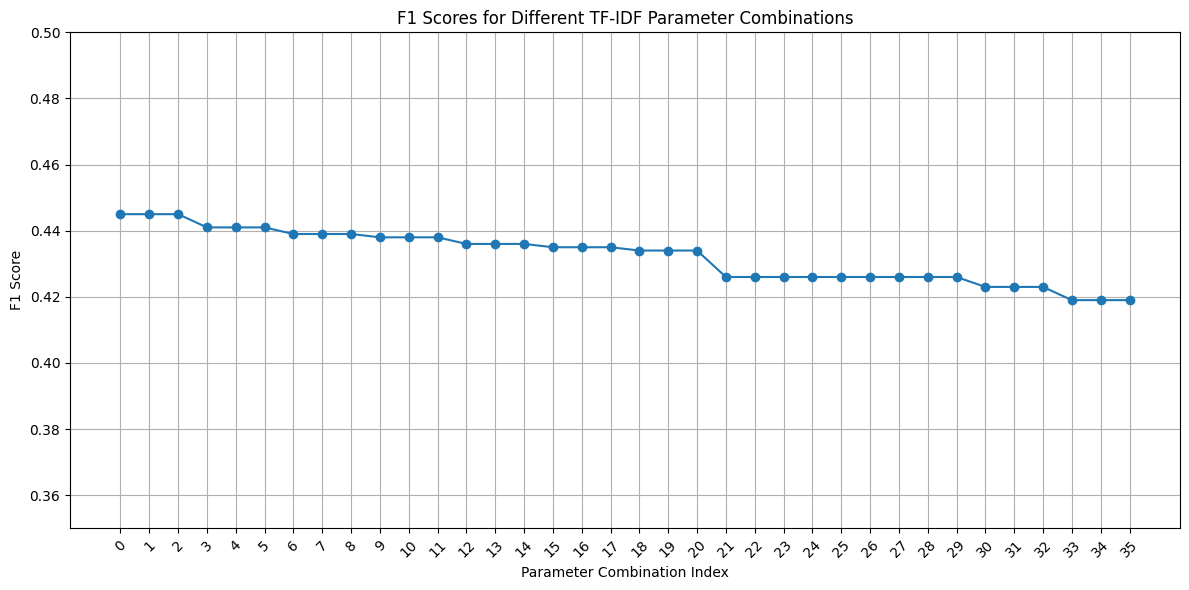

In [21]:
# Plot the f1 scores in as lineplot in descending order. y-min = 0, y-max = 1.0
plt.figure(figsize=(12, 6))
f1_scores = tf_idf_tuning_df.sort_values(by='f1', ascending=False)['f1']
index = range(len(f1_scores))
plt.plot(index, f1_scores, marker='o')
plt.xticks(index, tf_idf_tuning_df.sort_values(by='f1', ascending=False).index, rotation=45)
plt.xlabel('Parameter Combination Index')
plt.ylabel('F1 Score')
plt.ylim(0.35, 0.5)
plt.title('F1 Scores for Different TF-IDF Parameter Combinations')
plt.grid(True)
plt.tight_layout()
print("Top 6 parameter combinations:")
print(tf_idf_tuning_df.head(6))
plt.show()

# Balancing the Dataset

**Step 3:**
- **Purpose**: Balancing the dataset to compare the performance of the model on a balanced dataset vs an imbalanced dataset.
- **Vectorizers**: TF-IDF
- **Method**: Random oversampling and undersampling

To balance the dataset, I will use two different sampling techniques: random oversampling and random undersampling. Random oversampling will increase the number of disaster-related tweets by duplicating existing tweets, while random undersampling will decrease the number of non-disaster-related tweets by randomly removing tweets. I do not anticipate the different methods will result in significantly different performance, but it is worht testing both methods.


Currently the dataset is imbalanced with only about 20% of the data labeled as a disaster. Knowing that a Naive baseline for the inbalanced dataset is 0.186, an f1 score of 0.441 is more than twice that baseline. However, I want to see if balancing the dataset will significantly improve the performance of the model. I don't expect the performance to double, but I do expect it to improve.

In [22]:
from sklearn.utils import resample

def oversample_positive_class(df, target_col='target'):
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=42
    )

    df_balanced = pd.concat([df_majority, df_minority_upsampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced

def undersample_negative_class(df, target_col='target'):
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=42
    )

    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced



In [23]:
df_balanced = oversample_positive_class(df_train)
df_balanced_test = oversample_positive_class(df_test)
print(f"Balanced dataset shape: {df_balanced.shape}")

df_balanced_undersampled = undersample_negative_class(df_train)
df_balanced_undersampled_test = undersample_negative_class(df_test)
print(f"Balanced undersampled dataset shape: {df_balanced_undersampled.shape}")

Balanced dataset shape: (14810, 7)
Balanced undersampled dataset shape: (3382, 7)


#### Oversampled

**Step 3a - Oversampling**:
- **Purpose**: Oversampling the dataset to increase the number of disaster-related tweets.
- **Vectorizers**: TF-IDF
To oversample the dataset, I will use sklearn's resample module to resample with replacement, until the number of disaster-related tweets is equal to the number of non-disaster-related tweets. I will then use the same TFIDF vectorization parameters that were tuned in step 2 to vectorize the balanced dataset. I will then apply the NMF model to extract the number of topics that were tuned in step 1. I will then plot the f1 score for each of the topics and datasets, and compare the performance of the model on the balanced dataset vs the imbalanced dataset.

**Results**:
The f1 score for the oversampled dataset is 0.68, which is significantly higher than the f1 score of 0.445 for the imbalanced dataset. However, the improvement is not as significant as I expected. The oversampling did imporove performance, but not by a factor of two (impossible unless perfect) and it didn't improve the percentage point difference. The imbalanced dataset went from 18.6% to 44.1%, while the oversampled dataset went from 50% to 68%. 

In [24]:

# nmf_metrics_combined.csv exist, load it
if os.path.exists(os.path.join(DATA_DIR, "nmf_metrics_combined.csv")):
    metrics_combined_df = pd.read_csv(os.path.join(DATA_DIR, "nmf_metrics_combined.csv"))
else:
    X_vectorized_balanced = vectorizer.fit_transform(df_balanced['cleaned_text'])

    X_embed_balanced = embedding_model.encode(df_balanced['cleaned_text'], show_progress_bar=True)
    X_embed_balanced_norm = normalize(X_embed_balanced)
    X_embed_balanced_norm_positive = X_embed_balanced_norm - X_embed_balanced_norm.min()


    X_sources_balanced = {
        'tfidf_balanced': X_vectorized_balanced[df_balanced.index],
        'embedding_balanced': X_embed_balanced_norm_positive[df_balanced.index]
    }

    results_balanced = []

    for name, X in X_sources_balanced.items():
        print(f"\n📊 [Balanced] Vectorizer: {name}")
        
        for k in [5, 10, 15, 20, 30, 50, 100, 200, 300]:
            print(f"  ➤ NMF with {k} components...")
            result = run_nmf_and_score(X, df_balanced, n_components=k, threshold=0.2)
            result['vectorizer'] = name
            results_balanced.append(result)
        
    #all_combined = all_results + results_balanced

    metrics_balanced_df = pd.DataFrame([
        {
            'vectorizer': r['vectorizer'],
            'n_components': r['n_components'],
            'f1': round(r['f1'], 3),
            'precision': round(r['precision'], 3),
            'recall': round(r['recall'], 3),
        }
        for r in results_balanced
    ])
    # Append metrics_df and metrics_balanced_df
    metrics_combined_df = pd.concat([metrics_df, metrics_balanced_df], ignore_index=True)

    metrics_combined_df.to_csv(os.path.join(DATA_DIR, "nmf_metrics_combined.csv"), index=False)

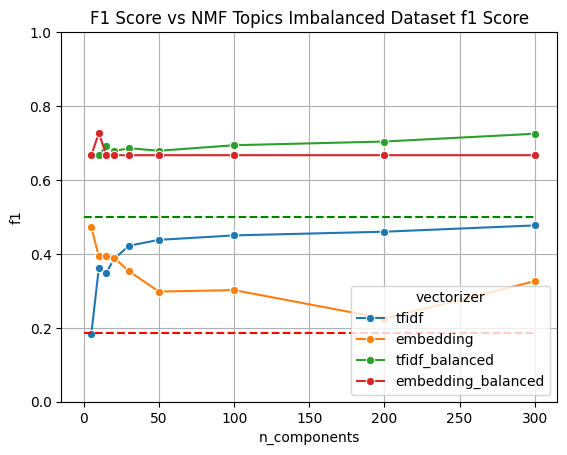

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=metrics_combined_df, x='n_components', y='f1', hue='vectorizer', marker='o')
plt.title("F1 Score vs NMF Topics Imbalanced Dataset f1 Score")
plt.ylim(0, 1)
plt.hlines(y = 0.185, xmin=0, xmax=300, color='red', linestyle='--', label='Baseline F1 Score')
plt.hlines(y = 0.5, xmin=0, xmax=300, color='green', linestyle='--', label='Balanced F1 Score')
plt.grid(True)
plt.show()


#### Undersampled

**Step 3b - Undersampling**:
- **Purpose**: Undersampling the dataset to compare the performance of the model on a balanced dataset vs an imbalanced dataset.
- **Vectorizers**: TF-IDF
To undersample the dataset, I will randomly remove non-disaster-related tweets until the number of disaster-related tweets is equal to the number of non-disaster-related tweets. This will create a balanced dataset with an equal number of disaster-related and non-disaster-related tweets. The goal is to see if this improves the performance of the model compared to the imbalanced dataset.

**Results**:
The undersampled dataset has 2,114 disaster-related tweets and 2,114 non-disaster-related tweets. The total number of tweets in the undersampled dataset is 4,228. The distribution of the labels is now balanced, with 50% disaster-related tweets and 50% non-disaster-related tweets. Plotting the performance of the models with the oversampled and baseline datasets, we can see that the undersampled dataset performs equivalent to the oversampled dataset, with an f1 score of 0.7 at n_components of 50. This is a significant improvement over the imbalanced dataset, which had an f1 score of 0.445 at n_components of 50. The undersampled dataset has a naive baseline of 0.5, so the model is performing significantly better than random chance. But, as expected, the performance didn't improve as much as the imblanced dataset from the naive baseline of 0.186 to 0.445.

In [26]:
#### Undersampling results
if os.path.exists(os.path.join(DATA_DIR, "nmf_metrics_combined_undersampled.csv")):
    metrics_combined_undersampled_df = pd.read_csv(os.path.join(DATA_DIR, "nmf_metrics_combined_undersampled.csv"))
else:

    X_vectorized_balanced_undersampled = vectorizer.fit_transform(df_balanced_undersampled['cleaned_text'])
    X_embed_balanced_undersampled = embedding_model.encode(df_balanced_undersampled['cleaned_text'], show_progress_bar=True)
    X_embed_balanced_undersampled_norm = normalize(X_embed_balanced_undersampled)
    X_embed_balanced_undersampled_norm_positive = X_embed_balanced_undersampled_norm - X_embed_balanced_undersampled_norm.min()
    print(f"min x_embed_balanced_undersampled_norm_positive: {X_embed_balanced_undersampled_norm_positive.min()}")

    X_sources_balanced_undersampled = {
        'tfidf_balanced_undersampled': X_vectorized_balanced_undersampled[df_balanced_undersampled.index],
        'embedding_balanced_undersampled': X_embed_balanced_undersampled_norm_positive[df_balanced_undersampled.index]
    }
    results_balanced_undersampled = []
    for name, X in X_sources_balanced_undersampled.items():
        print(f"\n📊 [Balanced Undersampled] Vectorizer: {name}")
        
        for k in [5, 10, 15, 20, 30, 50, 100, 200, 300]:
            print(f"  ➤ NMF with {k} components...")
            result = run_nmf_and_score(X, df_balanced_undersampled, n_components=k, threshold=0.2)
            result['vectorizer'] = name
            results_balanced_undersampled.append(result)
    #all_combined_undersampled = all_combined + results_balanced_undersampled
    metrics_undersampled_df = pd.DataFrame([
        {
            'vectorizer': r['vectorizer'],
            'n_components': r['n_components'],
            'f1': round(r['f1'], 3),
            'precision': round(r['precision'], 3),
            'recall': round(r['recall'], 3),
        }
        for r in results_balanced_undersampled
    ])
    metrics_combined_undersampled_df = pd.concat([metrics_combined_df, metrics_undersampled_df], ignore_index=True)
    
    metrics_combined_undersampled_df.to_csv(os.path.join(DATA_DIR, "nmf_metrics_combined_undersampled.csv"), index=False)

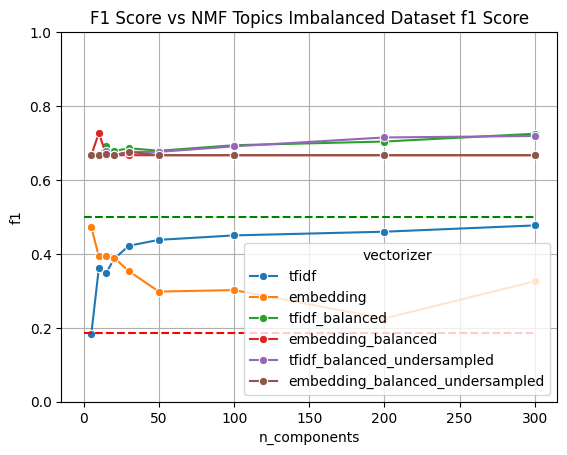

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=metrics_combined_undersampled_df, x='n_components', y='f1', hue='vectorizer', marker='o')
plt.title("F1 Score vs NMF Topics Imbalanced Dataset f1 Score")
plt.ylim(0, 1)
plt.hlines(y = 0.185, xmin=0, xmax=300, color='red', linestyle='--', label='Baseline F1 Score')
plt.hlines(y = 0.5, xmin=0, xmax=300, color='green', linestyle='--', label='Balanced F1 Score')
plt.grid(True)
plt.show()


## Notes on Dataset Performance

**Question:** Why did the TFIDF vectorization perform better than the embedding model?

**Answer:** The TFIDF vectorization performed better than the embedding model because NMF is designed to work with additive components, while the embedding model is a dense representation of the text data. The TFIDF vectorization produces a sparse matrix that allows the weights to be additive on the frequency of terms, which couples well with NMF's ability to find additive parts of the data. In contrast, the embedding model represents each tweet as a single point in a high-dimensional vector space, which does not allow for additive decomposition.

In addition to the embedding model performing worse, it also took significantly longer to fit the model. It required more resource to fit the embedding model, and the NMF model took longer to converge. This is likely due to the high dimensionality of the embedding model, which makes it more computationally expensive to fit the NMF model. 


**Question:** Did balancing the dataset improve the performance of the model?

**Answer:** Balancing the dataset did improve the raw value of the f1 score, but not by the same factor over the naive baseline of 0.5. The imbalanced dataset had an improvement of 0.186 to 0.441 (a difference of 0.255), while the balanced dataset had an improvement of 0.5 to 0.68 (a difference of 0.18). The performance improvement was not as significant as I expected. Overall, the vectorization and NMF model improve the imbalanced dataset's performance more than the balanced dataset's performance. This is ideal, as it means the model is able to better identify the disaster-related tweets without needing to balance the dataset. Since the application of this model won't have targets to balance, there isn't the opportunity to balance the dataset in a real-world scenario. 



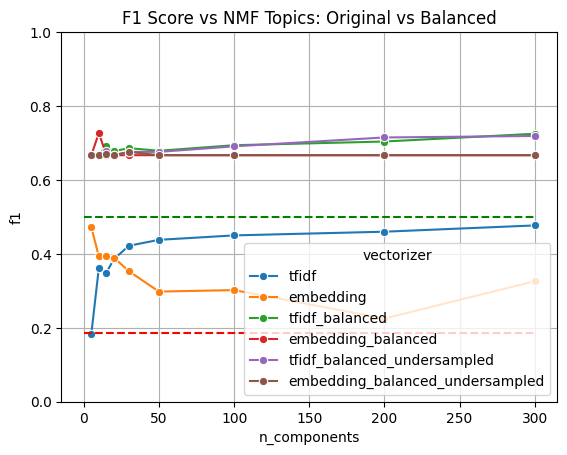

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt



sns.lineplot(data=metrics_combined_undersampled_df, x='n_components', y='f1', hue='vectorizer', marker='o')
plt.title("F1 Score vs NMF Topics: Original vs Balanced")
plt.ylim(0, 1)
plt.hlines(y = 0.185, xmin=0, xmax=300, color='red', linestyle='--', label='Baseline F1 Score')
plt.hlines(y = 0.5, xmin=0, xmax=300, color='green', linestyle='--', label='Balanced F1 Score')
plt.grid(True)
plt.show()


#### Individual Topic Metrics

Below is a granular breakdown of the model's performance based on the balanced dataset with individual classification metrics for each topic. This will help us understand how well the model is able to classify the tweets into their respective topics, determine any instances of overfitting, and understand the topic purity based on post-hoc labeling.

We can see that there are several instances of very high topic purity with reasonably high levels of support (number of tweets in the topic). Overall, I think that n_components of 50 is a good choice, as every topic has reasonable levels of support and a well distributed topic purity. I'll go into further detail in the results analysis section.

In [29]:
# Identifying individual topics and their labels

N = 50
fit_vectorizer_imbalanced = TfidfVectorizer(
    max_df=0.75,
    min_df=5,
    stop_words="english",
    token_pattern=r"\b[a-z]{2,}\b",  # Only keep words with 2 or more alphabetic characters
    ngram_range=(1, 2),
    lowercase=True,
).fit(df_train["cleaned_text"])
fit_vectorizer_balanced = TfidfVectorizer(
    max_df=0.75,
    min_df=5,
    stop_words="english",
    token_pattern=r"\b[a-z]{2,}\b",  # Only keep words with 2 or more alphabetic characters
    ngram_range=(1, 2),
    lowercase=True,
).fit(df_balanced["cleaned_text"])

fit_nmf_imbalanced = NMF(n_components=N, random_state=42, max_iter=500).fit(
    fit_vectorizer_imbalanced.transform(df_train["cleaned_text"])
)
fit_nmf_balanced = NMF(n_components=N, random_state=42, max_iter=500).fit(
    fit_vectorizer_balanced.transform(df_balanced["cleaned_text"])
)


def topic_labels(fit_vectorizer, fit_nmf, df, column_name, threshold=0.5):
    X_vectorized = fit_vectorizer.transform(df[column_name])
    W = fit_nmf.transform(X_vectorized)
    topic_assignments = W.argmax(axis=1)
    topic_label_df = evaluate_topic_labels(
        topic_assignments, df, target_col="target", threshold=threshold
    )

    return topic_label_df


# Get topic labels for imbalanced and balanced datasets
topic_labels_imbalanced = topic_labels(
    fit_vectorizer_imbalanced,
    fit_nmf_imbalanced,
    df_train,
    "cleaned_text",
    threshold=0.186,
)
topic_labels_balanced = topic_labels(
    fit_vectorizer_balanced,
    fit_nmf_balanced,
    df_balanced,
    "cleaned_text",
    threshold=0.5,
)
print("\n\nTopic Labels for Imbalanced Dataset:\n")
print(topic_labels_imbalanced)
print("\n\nTopic Labels for Balanced Dataset:\n")
print(topic_labels_balanced)



Topic Labels for Imbalanced Dataset:

    topic  assigned_label  disaster_rate  support  precision  recall     f1
33     33               1          0.530      151      0.530     1.0  0.693
16     16               1          0.497      171      0.497     1.0  0.664
12     12               1          0.471       68      0.471     1.0  0.640
20     20               1          0.448      163      0.448     1.0  0.619
9       9               1          0.441      213      0.441     1.0  0.612
44     44               1          0.388      152      0.388     1.0  0.559
41     41               1          0.364      228      0.364     1.0  0.534
48     48               1          0.348      233      0.348     1.0  0.516
13     13               1          0.330      194      0.330     1.0  0.496
36     36               1          0.312      192      0.312     1.0  0.476
14     14               1          0.309      204      0.309     1.0  0.472
11     11               1          0.298      35

# Results and Classification Report

Below is a classification report for the balanced dataset with the **TFIDF vectorization** and **NMF model**. 

The parameters used were the best performing parameters from the hyperparameter tuning section:
- **max_df**: 0.75
- **min_df**: 5
- **ngram_range**: (1, 2)
- **token_pattern**: \b[a-z]{2,}\b
- **stop_words**: english
- **lowercase**: True
- **max_features**: 1500
- **n_components**: 50 


The classification report includes precision, recall, f1 score, and support for each class. The overall f1 score for the model is **0.450 for the positive class and 0.770 for the negative** class. For a purely unsupervised model, an f1 score on a dataset, where the **naive baseline is 0.186**, of 0.450 is a good starting point. We know the model is not overfitting, as the metrics for the test set are similar to the training set. The model is able to identify generalize the topics in the dataset, and the post-hoc labeling of the topics show that the model is able to identify disaster-related tweets with a reasonable level of accuracy.

To better improve the model, an ensemble method could be used to combine the predictions of multiple models to have a more robust prediction. This could be done by combining the TFIDF/NMF model combination with embedding/kmeans clustering, or other unsupervised NLP methods.

In [30]:
# Define best vectorizer
best_vectorizer = TfidfVectorizer(
    max_df=0.75,
    min_df=5,
    stop_words='english',
    token_pattern=r'\b[a-z]{2,}\b',  # Only keep words with 2 or more alphabetic characters
    ngram_range=(1, 2),
    lowercase=True,
)

best_nmf = NMF(n_components=50, random_state=42, max_iter=500)

def fit_pred_best_vec_nmf(df_train, df_test, vectorizer, nmf_model, train_col, test_col, threshold=0.5):
    
    df_train = df_train.copy()
    df_test = df_test.copy()

    # Fit vectorizer on training data
    vectorizer.fit(df_train[train_col])
    
    # Transform training and test data
    X_train = vectorizer.transform(df_train[train_col])
    X_test = vectorizer.transform(df_test[test_col])
    
    # Fit NMF model on training data
    nmf_model.fit(X_train)
    
    # Transform both training and test data
    W_train = nmf_model.transform(X_train)
    W_test = nmf_model.transform(X_test)
    
    # predict topics for both training and test data
    train_topic_assignments = W_train.argmax(axis=1)
    test_topic_assignments = W_test.argmax(axis=1)
    
    # Topic labels
    train_topic_labels = evaluate_topic_labels(train_topic_assignments, df_train,threshold=0.186)
    test_topic_labels = evaluate_topic_labels(test_topic_assignments, df_test,threshold=0.186)
    
    # Map topic labels to the original dataframes
    df_train['topic'] = train_topic_assignments
    df_test['topic'] = test_topic_assignments
    
    # Create separate topic->label maps for train and test
    topic_to_label_train = dict(zip(train_topic_labels['topic'], train_topic_labels['assigned_label']))
    topic_to_label_test = dict(zip(test_topic_labels['topic'], test_topic_labels['assigned_label']))

    # Apply mapping to each row
    df_train['predicted_label'] = df_train['topic'].map(topic_to_label_train)
    df_test['predicted_label'] = df_test['topic'].map(topic_to_label_test)
    
    return df_train, df_test, vectorizer, nmf_model
    

##### Inbalanced Dataset

🔍 Classification Report (Imbalanced Training):
              precision    recall  f1-score   support

           0      0.903     0.682     0.777      7405
           1      0.328     0.679     0.442      1691

    accuracy                          0.682      9096
   macro avg      0.615     0.681     0.610      9096
weighted avg      0.796     0.682     0.715      9096

🧱 Confusion Matrix:
🔍 Classification Report (Imbalanced Test):
              precision    recall  f1-score   support

           0      0.911     0.667     0.770      1851
           1      0.329     0.714     0.450       423

    accuracy                          0.675      2274
   macro avg      0.620     0.690     0.610      2274
weighted avg      0.802     0.675     0.710      2274

🧱 Confusion Matrix:


Text(0.5, 1.0, 'Confusion Matrix - Imbalanced Test Set')

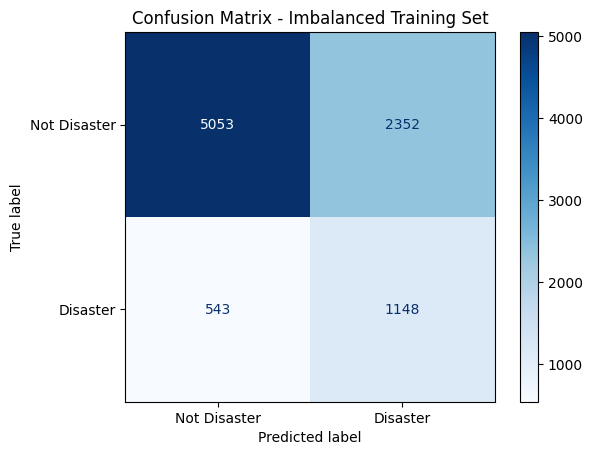

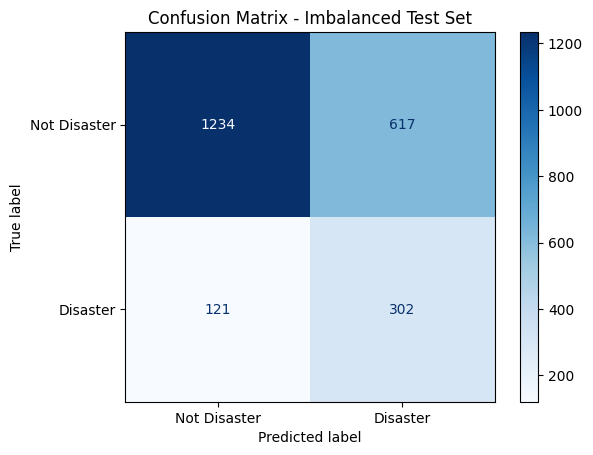

In [31]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Step 1: Get disaster rate per topic and assign labels
df_train_pred, df_test_pred, best_vectorizer, best_nmf = fit_pred_best_vec_nmf(
    df_train,
    df_test,
    best_vectorizer,
    best_nmf,
    "cleaned_text",
    "cleaned_text",
    0.186,
)

# Step 2: Get y_true and y_pred for training and test sets
y_true_train = df_train_pred["target"]
y_pred_train = df_train_pred["predicted_label"]
y_true_test = df_test_pred["target"]
y_pred_test = df_test_pred["predicted_label"]

# Step 3: Generate classification report and confusion matrix
print("🔍 Classification Report (Imbalanced Training):")
print(classification_report(y_true_train, y_pred_train, digits=3))

print("🧱 Confusion Matrix:")
cm = confusion_matrix(y_true_train, y_pred_train)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"]
)
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix - Imbalanced Training Set")

print("🔍 Classification Report (Imbalanced Test):")
print(classification_report(y_true_test, y_pred_test, digits=3))
print("🧱 Confusion Matrix:")
cm_test = confusion_matrix(y_true_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test, display_labels=["Not Disaster", "Disaster"]
)
disp_test.plot(cmap="Blues")
disp_test.ax_.set_title("Confusion Matrix - Imbalanced Test Set")

# Discussion

- **Why did embedding do so poorly, compared to TFIDF vectorization?**

During the initial investigation, I was very interested in determining if embedding models would outperform TFIDF vectorization. However, the results show that the TFIDF vectorization significantly outperformed the embedding model. I learned that it's because the embedding model is a **dense representation** of the text data in a vector space designed to encode semantic meaning, not additive composition. TFIDF is able to vectorize the text data into a sparse matrix that allows the weights to be additive on the frequency of terms, which couples very well with Non-Negative Matrix Factorization's of the data into additive components. Because of this, the embedding model was quickly discarded after the hyperparameter tuning step for the NMF model of number of components. However, it is worth noting that embedding models can still be useful for other tasks, such as **clustering similar tweets or finding semantic similarity** between tweets. This could then be used in an ensemble method to improve the performance of the model.

- **Why was this NMF method better suited for TFIDF vectorization?**

TF-IDF vectorization produces a **sparse** matrix that allows the weights to be additive based on the frequency of terms contained in the tweets. This is ideal for Non-Negative Matrix Factorization, which is designed to decompose a matrix into **additive components**. The NMF algorithm finds the topics in the data by identifying the **latent structure** in the data<sup>2</sup>, which is well-suited for the sparse representation of teh text data produced by TF-IDF vectorization.

- **Why did the number of components plateau?**

The number of components plateaued around 50 because the model was able to extract the **most relevant topics** from the data. After a certain point, adding more components didn't significantly improve the model's performance, only increased the dimensionality of the data and the **risk of overfitting**. The plateau indicates that the model has captured the most important topics in the dataset. It should be noted that the dataset was curated by searching for keywords related to disasters. If the entire corpus of twitter is to be used, then the number of components will need to be increased to capture the additional topics in the data related to other disasters not currently in the dataset. The number of components set to 50 is only relevant to the current dataset.

- **Why did balancing the dataset not improve performance as much as expected?**

Before balancing the dataset, the model was able to identify disaster-related tweets with a reasonable level of accuracy. The imbalanced dataset had an **f1 score of 0.445**, which is more than twice the naive baseline of 0.186 (**raw f1 score increase of 0.259**). After balancing the dataset, the model was able to identify disaster-related tweets with an **f1 score of 0.68** (**raw f1 score increase of 0.18**). The performance improvement was not as significant as expected, likely because the model was already able to identify the most relevant topics in the data. Since TFIDF is an additive representation of the text data, the most informative disaster-related tweets were already strongly weighted and well-separated in the orignal feature space,  allowing NMF to isolate the disaster topics without needing to balance the dataset. This outcome is ideal for real-world applications, as the overall volume of disaster-related tweets is likely to be imbalanced, and the model is still able to identify the most relevant topics. TFIDF representation coupled with NMF topic modeling was able to identify meaningful **disaster-related topics without requiring a balanced dataset**; thus, suggesting this approach is robust to imbalanced datasets.

- **How can this be applied to a real-world scenario?**

In a real-world scenario, this approach can be used to initially identify disaster-related tweets from a large corpus of tweets. This can be the initial filter to identify tweets, as it doesn't require a label or balance dataset to perform well. Then, additional monitoring could be done to determine if there is an up tick in disaster-related tweets/topics. This could then be used as a trigger for human review or intervention. Because the inference pipeline has two steps, the first being the **TFIDF vectorization** of the tweet and the second being the **NMF topic modeling**, it can be easily added to a **pipeline to process tweets in real-time**. 


# Conclusion

This project explored the use of TFIDF vectorization and NMF topic modeling to identify disaster-related tweets from a dataset of tweets. The results showed that TFIDF vectorization significantly outperformed embedding models, and that balancing the dataset did not improve performance as much as expected. The model was able to identify the latent topics in the data and classify the tweets into disaster-related topics with a reasonable level of accuracy, considering the naive baseline of 0.186. The model was able to achieve an f1 score of 0.445 on the imbalanced test dataset. This approach can be used in real-world scenarios to identify disaster-related tweets from a large corpus of tweets, and can be easily integrated into a pipeline to process tweets in real-time.

**Key Takeaways**:
- **TFIDF vectorization significantly outperformed embedding models** for NMF topic modeling.
- **Balancing** the dataset **did not improve performance** as much as expected, likely because the model was already able to identify the most relevant topics in the data.
- Hyperparameter tuning showed that **bigrams outperformed unigrams**, and that the **number of components** plateaued around **50**.
- Inference **pipeline** is very **fast** and doesn't require labels or a balanced dataset to perform well; thus, can be added to a tweet digestion pipeline
- **Embedding** models may still offer value for **clustering** similar tweets or finding **semantic similarity**, but are not suitable for NMF topic modeling.

Overall, the unsupervised approach is **efficient, interpretable, and scalable**; potentially making it a valuable tool for disaster-related tweet classification. Future work could explore the use of embedding models for clustering similar tweets or finding semantic similarity, as well as the use of ensemble methods to improve the performance of the model. Additionally, the model could be applied to other domains where identifying latent topics in the text data is important.

# References

[1]
Viktor S, “Disaster Tweets,” Kaggle.com, 2020. https://www.kaggle.com/datasets/vstepanenko/disaster-tweets (accessed May 18, 2025).

[2]
S. J. Kim, “Let us Extract some Topics from Text Data - Part III: Non-Negative Matrix Factorization (NMF) | Towards Data Science,” Towards Data Science, Dec. 14, 2022. https://towardsdatascience.com/let-us-extract-some-topics-from-text-data-part-iii-non-negative-matrix-factorization-nmf-8eba8c8edada/ (accessed Jun. 01, 2025).
‌

‌[3]
Neural Ninja, “TF-IDF: Weighing Importance in Text - Let’s Data Science,” Let’s Data Science, Jun. 30, 2023. https://letsdatascience.com/tf-idf/ (accessed Jun. 01, 2025).
‌

[4]
“Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation,” scikit-learn, 2025. https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html (accessed Jun. 01, 2025).
‌

[5]
“SentenceTransformers Documentation — Sentence Transformers documentation,” Sbert.net, 2019. https://www.sbert.net/ (accessed Jun. 01, 2025).
‌